# Trabajo Practico 1 - Que No Se Escape Nadie (?)

## Introduccion:

En el presente trabajo se analizara una base de datos de la empresa FIUBAFIP con el objetivo de entender la informacion que fue recolectada y poder predecir aquellas personas que tiene alto o bajo poder adquisitivo. 

### Objetivos:

- Entender la base de datos.
- Ver cómo los datos se relacionan entre si.
- Poder sacar alguna conclusión o descubrir un patrón a partir de estos.
- Indicar cuáles son los factores más importantes que determinan el poder adquisitivo de una persona.
- Poder llegar a armar un baseline

### Bibliotecas utilizadas:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

### Funciones de plot usadas

## Feature enginnering:

In [2]:
GSPREADHSEET_DOWNLOAD_URL = ("https://docs.google.com/spreadsheets/d/{gid}/export?format=csv&id={gid}".format)
FIUFIP_GID = '1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0'
df = pd.read_csv(GSPREADHSEET_DOWNLOAD_URL(gid=FIUFIP_GID), skiprows=0)

Antes de iniciar una analisis sobre unos datos, debemos verificar que no contiene informacion invalida o que no sea util para el analisis.

Inicialmente buscaremos missings (atributos que no fueron cargados).

In [3]:
df.isna().any()

anios_estudiados                              False
barrio                                         True
categoria_de_trabajo                           True
edad                                          False
educacion_alcanzada                           False
estado_marital                                False
ganancia_perdida_declarada_bolsa_argentina    False
genero                                        False
horas_trabajo_registradas                     False
religion                                      False
rol_familiar_registrado                       False
tiene_alto_valor_adquisitivo                  False
trabajo                                        True
dtype: bool

Como podemos ver existen 3 campos en donde no tenemos la informacion de todas las instancias. Por lo que ahora deberemos analizar cada situacion y tomar un criterio para decidir que hacer con estos instancias con valores invalidos.

Con este script podemos ver cuantas instancias tiene nulos y en que campos. De esta manera vemos que existe 27 personas que no completar las columans barrio, categoria_de_trabajo y trabajo. Al ser un grupo pequeño y tener valores invalidos en categoria que a priori parecen ser relevantes (categoria_de_trabajo y trabajo) decidimos descartalos.

In [4]:
def tiene_n_missings(x, n):
    acum = 0
    for i in range(len(x)):
        if x[i]:
            acum += 1
    return n <= acum


lista_de_missings = [tiene_n_missings(x, 3) for x in df.isna().to_numpy()]

df_3_missings = df.reset_index()[lista_de_missings].set_index('index')
df_3_missings.isnull().sum()

anios_estudiados                               0
barrio                                        27
categoria_de_trabajo                          27
edad                                           0
educacion_alcanzada                            0
estado_marital                                 0
ganancia_perdida_declarada_bolsa_argentina     0
genero                                         0
horas_trabajo_registradas                      0
religion                                       0
rol_familiar_registrado                        0
tiene_alto_valor_adquisitivo                   0
trabajo                                       27
dtype: int64

In [5]:
df.drop(df_3_missings.index, inplace = True)

Luego hacemos la misma logica para analizar a las personas con 2 campos nulos 

In [6]:
lista_de_missings = [tiene_n_missings(x, 2) for x in df.isna().to_numpy()]

df_2_missings = df.reset_index()[lista_de_missings].set_index('index')
df_2_missings.isnull().sum()

anios_estudiados                                 0
barrio                                           0
categoria_de_trabajo                          1809
edad                                             0
educacion_alcanzada                              0
estado_marital                                   0
ganancia_perdida_declarada_bolsa_argentina       0
genero                                           0
horas_trabajo_registradas                        0
religion                                         0
rol_familiar_registrado                          0
tiene_alto_valor_adquisitivo                     0
trabajo                                       1809
dtype: int64

Podemos notar que existen una gran cantidad de personas que no contesto cual es su trabajo. Como inicialmente el campo trabajo es una valor a tener en cuenta para poder decidir el valor adquisitivo decidimos crear un nuevo campo "No contesto" para no tener que descartar todos estos datos.

In [7]:
df = df.replace({'trabajo': np.nan, 'categoria_de_trabajo': np.nan},'No contesto')
df['trabajo'].isna().any() 

False

Por ultimo nos queda analizar cuantas son las instancias con un Nan. 

Como podemos ver existen 556 personas que no completaron su barrio. En esta ocasion decidimos analizar la cantidad de personas que viven en todos los barrios. Podemos notar que mas de un 90% vive en Palermo por lo que nos resulto correcto incluir a estas instancias en este barrio.

In [8]:
lista_de_missings = [tiene_n_missings(x, 1) for x in df.isna().to_numpy()]

df_missing = df.reset_index()[lista_de_missings].set_index('index')
df_missing.isnull().sum()

anios_estudiados                                0
barrio                                        556
categoria_de_trabajo                            0
edad                                            0
educacion_alcanzada                             0
estado_marital                                  0
ganancia_perdida_declarada_bolsa_argentina      0
genero                                          0
horas_trabajo_registradas                       0
religion                                        0
rol_familiar_registrado                         0
tiene_alto_valor_adquisitivo                    0
trabajo                                         0
dtype: int64

In [9]:
df['barrio'].value_counts(normalize = True)

Palermo                0.912190
Belgrano               0.020108
San Isidro             0.006192
Villa Urquiza          0.004284
Recoleta               0.003784
La Boca                0.003565
Agronomia              0.003315
Almagro                0.003127
Balvanera              0.002971
Puerto Madero          0.002814
Caballito              0.002533
Boedo                  0.002502
Barracas               0.002345
Chacarita              0.002283
Coghland               0.002189
Floresta               0.002095
Constitucion           0.002001
Colegiales             0.001939
Flores                 0.001876
Liniers                0.001845
Monte Castro           0.001595
Mataderos              0.001376
Nueva Pompeya          0.001345
Monserrat              0.001157
nuñez                  0.001063
Parque Chacabuco       0.000969
Parque Avellaneda      0.000907
Villa Luro             0.000907
Parque Chas            0.000876
La Paternal            0.000751
Retiro                 0.000625
Villa So

In [10]:
df = df.replace({'barrio': np.nan},'Palermo')

Al hacer este analsis notamos la gran cardinalidad de la variable barrio. Para poder analizar mas facilmente esta variable decidimos agrupar a los disintos barrios por sus comunas.

In [11]:
mapa = {'Palermo' : 'C14','Belgrano' : 'C13','San Isidro' : 'S.I','Villa Urquiza' : 'C12','Recoleta' : 'C2','La Boca' : 'C4','Agronomia' : 'C15','Almagro' : 'C5','Balvanera' : 'C3','Puerto Madero' : 'C1','Caballito' : 'C6','Boedo' : 'C5','Barracas' : 'C4','Chacarita' : 'C15','Coghland' : 'C12','Floresta' : 'C10','Constitucion' : 'C1','Colegiales' : 'C13','Flores' : 'C7','Liniers' : 'C9','Monte Castro' : 'C10','Mataderos' : 'C9','Nueva Pompeya' : 'C4','Monserrat' : 'C1','nuñez' : 'C13','Parque Chacabuco' : 'C7','Parque Avellaneda' : 'C9','Villa Luro' : 'C10','Parque Chas' : 'C15','La Paternal' : 'C15','Retiro' : 'C1','Villa Devoto' : 'C11','Villa Soldati' : 'C8','San Telmo' : 'C1','Villa Real' : 'C10','Santa Rita' : 'C11','Villa General Mitre' : 'C11','Versalles' : 'C10','Velez Sarsfield' : 'C10','Villa Pueyrredon' : 'C12','Cilla Riachuelo' : 'C8'}
df['comuna'] = df['barrio'].apply(lambda x: mapa.get(x))

Notamos que existe un grupo de gente que apesar de figurar como sin trabajo tiene un numero mayor a cero de horas_de_trabajo_registrada. Decidimos descartarlas por ser instancias con informacion contradictoria.

In [12]:
df_gente_sin_trabajo_con_horas_registradas = df[(df['categoria_de_trabajo'] == 'sin_trabajo') & (df['horas_trabajo_registradas'] > 0)]
df.drop(df_gente_sin_trabajo_con_horas_registradas.index, inplace = True)

Luego analizando las variables por separadado encontramos que para dos variables distintas existen dos categorias similares, las cueles presentan la misma distribucion pero una de ellas con una varianza mayor debido a tener pocas muestras.

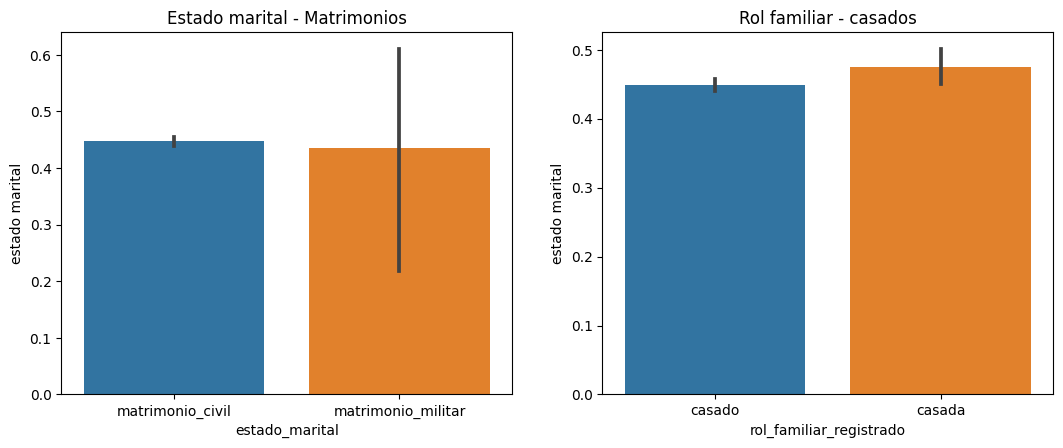

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)
sns.barplot(
    data=df[(df['estado_marital'] == 'matrimonio_civil') | (df['estado_marital'] == 'matrimonio_militar')],
    y='tiene_alto_valor_adquisitivo',
    x='estado_marital', ax=axes[0])

axes[0].set_title("Estado marital - Matrimonios")
axes[0].set_ylabel("estado marital")

sns.barplot(
    data=df[(df['rol_familiar_registrado'] == 'casado') | (df['rol_familiar_registrado'] == 'casada')],
    y='tiene_alto_valor_adquisitivo',
    x='rol_familiar_registrado', ax=axes[1])

axes[1].set_title("Rol familiar - casados")
axes[1].set_ylabel("estado marital")

plt.show()

Como podemos observar en los graficos la informacion que aporta para estimar a la funcion target, el matrimonio civil y el militar es exactamente la misma (lo mismo ocurre para cadao y casada). Es por ello que decidimos combinarlas en una misma categoria.

In [14]:
df['rol_familiar_registrado'] = df['rol_familiar_registrado'].apply(lambda x: 'casado' if x == 'casada' else x)
df['estado_marital'] = df['estado_marital'].apply(lambda x: 'matrimonio' if x == 'matrimonio_civil' or x == 'matrimonio_militar' else x)

Tambien podemos notar que eduacion alzancada y años estudidados nos aportan la misma informacion. Una es una simple categorizacion de la otra como se puede observar:

In [15]:
mapa = {'preescolar': 1,
        '1-4_grado': 4,
        '5-6_grado': 6,
        '7-8_grado': 8,
        '9_grado': 9,
        '1_anio': 10,
        '2_anio': 11,
        '3_anio': 12,
        '4_anio': 13,
        '5_anio': 14,
        'universidad_1_anio': 15,
        'universidad_2_anio': 16,
        'universidad_3_anio': 17,
        'universidad_4_anio': 18,
        'universiada_5_anio' : 19,
        'universiada_6_anio' : 20}
educacion_alcanzada = df['educacion_alcanzada'].apply(lambda x: mapa.get(x))
df['anios_estudiados'].equals(educacion_alcanzada)

True

Por lo tanto como no se pierde informacion y para poder reducir la dimensionalidad se decide eliminar esta columna redundante

In [16]:
df = df.drop(['educacion_alcanzada'],axis=1)

## Analisis de los datos:

Para el análisis empezamos haciendonos algunas preguntas, y en cada caso al surgir alguna nueva pregunta interesante se continuara su desarrollo en esa sección.

- ¿Que tanto influye tener una familia en el poder adquisitivo?
- ¿Operar con la bolsa da evidencia de un inversor de mayor capital?
- ¿Que profesiones son mas determinantes?
- ¿Que nivel de formacion academica es necesaria?
- ¿Es realmente influyente el domicilio legal?
- Tomando a la edad como un indicador promedio en la experiencia laboral. ¿Que tanto peso tiene con respecto a la capacidad financiera?

#### Constantes globales

Se definen las siguientes constantes para evitar repetir codigo

In [17]:
df_alto_valor_ad = df[df.tiene_alto_valor_adquisitivo == 1]
df_bajo_valor_ad = df[df.tiene_alto_valor_adquisitivo == 0]

### ¿Que tanto influye tener una familia en el poder adquisitivo?

Para responder esta pregunta inicialmente podemos hacer el siguiente grafico que muestra a los distintos estados maritales y su porcentaje de personas que poseen alto valor adquisitivo

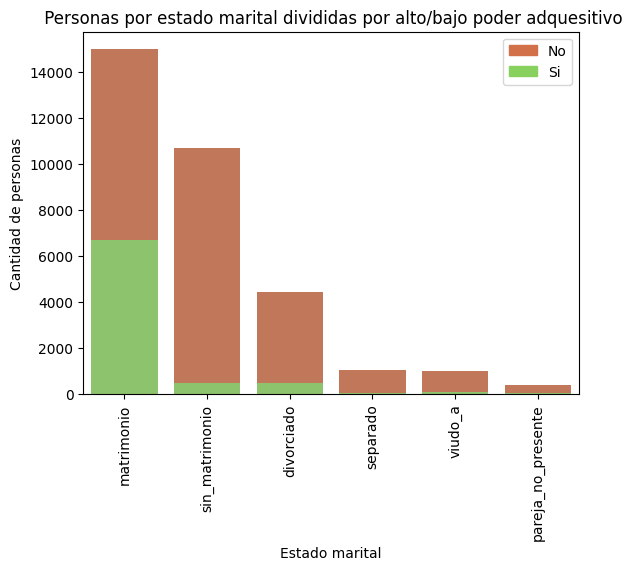

In [18]:
plt.figure(figsize=(6.4, 4.8),  dpi=100)

def stacked_barplot(df, categoria, ax=None):
    total = df.groupby(categoria)['tiene_alto_valor_adquisitivo'].sum().reset_index()
    alto_valor = df[df.tiene_alto_valor_adquisitivo == 1].groupby(categoria)['tiene_alto_valor_adquisitivo'].sum().reset_index()

    alto_valor['tiene_alto_valor_adquisitivo'] = df[df.tiene_alto_valor_adquisitivo == 1].groupby(categoria)['tiene_alto_valor_adquisitivo'].sum().reset_index()['tiene_alto_valor_adquisitivo'].tolist()
    total['tiene_alto_valor_adquisitivo'] = df.groupby(categoria)['anios_estudiados'].apply(lambda x: len(x)).tolist()

    bar1 = sns.barplot(y="tiene_alto_valor_adquisitivo",  x="estado_marital", data=total, color='#D17049', order = total.sort_values('tiene_alto_valor_adquisitivo', ascending = False)['estado_marital'])
    bar2 = sns.barplot(y="tiene_alto_valor_adquisitivo", x="estado_marital", data=alto_valor, color='#89D15E', order = total.sort_values('tiene_alto_valor_adquisitivo', ascending = False)['estado_marital'], ax=No)
    top_bar = mpatches.Patch(color='#D17049', label='No')
    bottom_bar = mpatches.Patch(color='#89D15E', label='Si')
    return (top_bar, bottom_bar)

(top_bar, bottom_bar) = stacked_barplot(df, 'estado_marital')

plt.legend(handles=[top_bar, bottom_bar])
plt.title(" Personas por estado marital divididas por alto/bajo poder adquesitivo")
plt.ylabel("Cantidad de personas")
plt.xlabel("Estado marital")
plt.xticks(rotation = 90)

plt.show()


Podemos notar una marcada diferencia para las personas que tienen un matrimonio siendo el 45% de las personas en matrimonio personas con alto poder adquisitivo, en comparacion a las demas posibilidades que poseen un promedio similar de aproximadamente el 10% de personas con alto poder adquisitivo,  Tambien nos parece importante resltrar la separacion entre la poblacion que cumple tener poder adquisitivo alto y la que no, como vemos la gran mayoria de las personas con poder adquisitivo alto estan casadas, mientras que en el caso contrario la mayoria no posee matrimonio, consideramos que esta puede ser una buena regla de decision

#### ¿Como se relaciona con el rol familiar?

Para ello se nos ocurrio un heatmap que evidencie si hay correlacion entre una y la otra

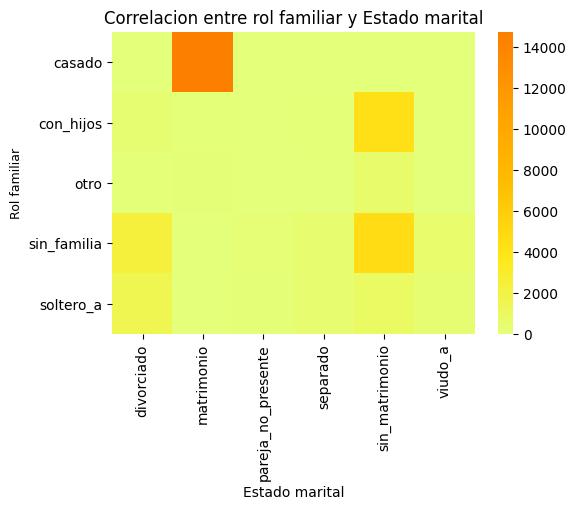

In [19]:
df_temp = df.copy()
df_temp['unos'] = [1] * 32527
df_estado_marital= pd.pivot_table(
    df_temp,
    'unos',
    'rol_familiar_registrado',
    'estado_marital',
    'count',
).sort_index()
#Elimino intersecciones nulas
df_estado_marital = df_estado_marital.replace({np.nan: 0})

plt.figure(dpi=100)
plt.ylabel("Cómo cr", fontsize=9)
ax = sns.heatmap(df_estado_marital, square=True, cmap="Wistia")
ax.set(xlabel='Estado marital', ylabel='Rol familiar', title='Correlacion entre rol familiar y Estado marital')
plt.show()

Como era de esperarse la relacion entre estas dos variables es bastante estrecha ya que la gran mayoria de la gente que esta casada esta en un matrimonio, mientras que en el resto de variables la variacion es muy pequeña

### ¿Operar con la bolsa da evidencia de un inversor de mayor capital?

A priori una pregunta trivial es preguntarse si el hecho de poder operar con la bolsa de alguna manera tiene aparejado tener poder adquisitivo alto, como el atributo de ganancia o perdida declarada bolsa argentina, esta gobernado por una gran mayoria de gente que no ha tenido perdidas ni ganancias decidimos primero categorizar esta variable en Perdida, Ganancia o Cero en caso de no haber obtenido ganancia ni perdida, para poder observar mas facilmente su relacion con el poder adquisitivo

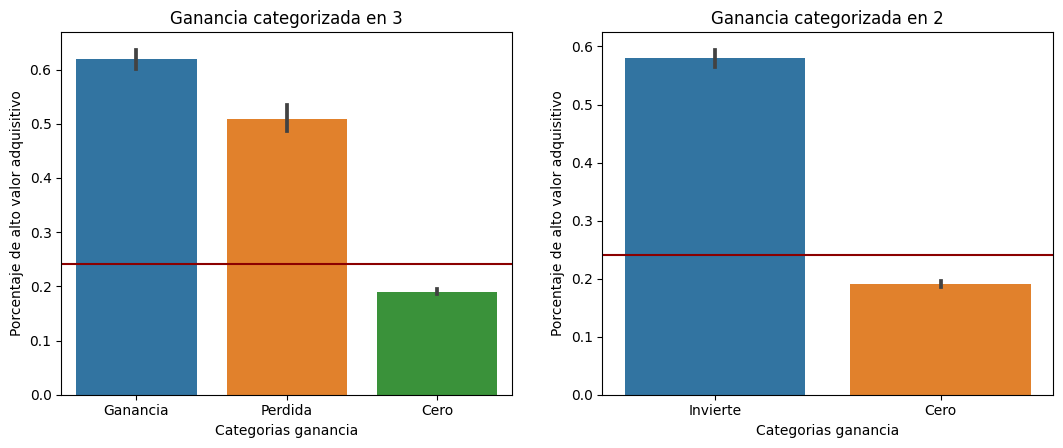

In [20]:
def categorizar_ganancia(df, categorizar_por):
    df_cat = df[['ganancia_perdida_declarada_bolsa_argentina','tiene_alto_valor_adquisitivo']].copy()
    df_cat['ganancia'] = df_cat['ganancia_perdida_declarada_bolsa_argentina'].apply(categorizar_por)
    df_cat['ganancia'].value_counts()
    indices_cat = df_cat.groupby('ganancia')['tiene_alto_valor_adquisitivo'].aggregate(lambda x: np.mean(x))
    return (df_cat, indices_cat)

df_gan_3_cat, indices_3_cat = categorizar_ganancia(df,lambda gan: 'Cero' if gan == 0 else ('Perdida' if gan < 0 else 'Ganancia'))
df_gan_2_cat, indices_2_cat = categorizar_ganancia(df,lambda gan: 'Cero' if gan == 0 else 'Invierte')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)
prom = df['tiene_alto_valor_adquisitivo'].mean()
sns.barplot(
    data=df_gan_3_cat,
    x='ganancia',
    y='tiene_alto_valor_adquisitivo',
    order= indices_3_cat.sort_values(ascending=False).index,
    ax=axes[0])
axes[0].set(title="Ganancia categorizada en 3",xlabel="Categorias ganancia",ylabel="Porcentaje de alto valor adquisitivo")
axes[0].axhline(prom, color="darkred", label="Promedio de personas con alto VA")

sns.barplot(
    data=df_gan_2_cat,
    x='ganancia',
    y='tiene_alto_valor_adquisitivo',
    order= indices_2_cat.sort_values(ascending=False).index,
    ax=axes[1])


axes[1].set(title="Ganancia categorizada en 2",xlabel="Categorias ganancia",ylabel="Porcentaje de alto valor adquisitivo")
axes[1].axhline(prom, color="darkred", label="Promedio de personas con alto VA")


plt.show()

Como se puede apreciar el grafico de la izquierda transmite la misma informacion que el de la derecha, en el sentido que aun teniendo perdida el accionista tiene un porcentaje comparable al que registro una ganancia, es por ello que nos parece apropiado agruparlo en una categoria llamada Invierte. Otra cosa a notar es que como era de esperarse alguien que invierte tiene mayor poder adquisitivo que la media.

### ¿Que profesiones son mas determinantes?

Sabemos que distintas profesiones tienen distintos ingresos, por lo tanto podriamos esperar que las profesiones con mayor remuneracion tengan un mayor porcentaje con alto poder adquisitivo.

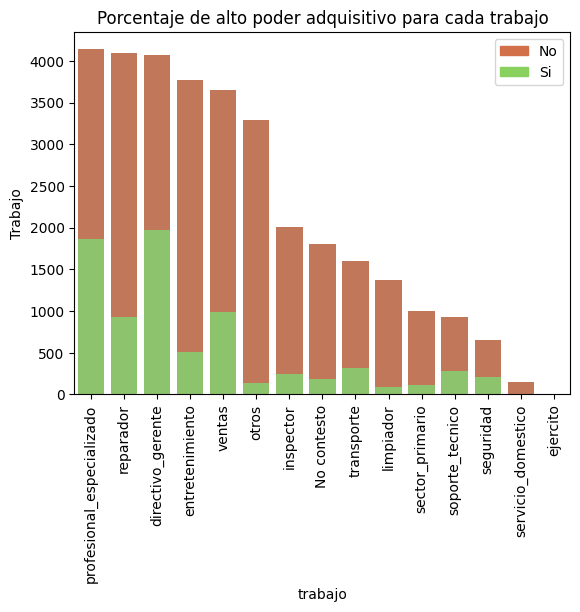

In [21]:
plt.figure(figsize=(6.4, 4.8),  dpi=100)

total = df.groupby('trabajo')['tiene_alto_valor_adquisitivo'].sum().reset_index()
alto_valor = df[df.tiene_alto_valor_adquisitivo == 1].groupby('trabajo')['tiene_alto_valor_adquisitivo'].sum().reset_index()

alto_valor['tiene_alto_valor_adquisitivo'] = df[df.tiene_alto_valor_adquisitivo == 1].groupby('trabajo')['tiene_alto_valor_adquisitivo'].sum().reset_index()['tiene_alto_valor_adquisitivo'].tolist()
total['tiene_alto_valor_adquisitivo'] = df.groupby('trabajo')['anios_estudiados'].apply(lambda x: len(x)).tolist()

bar1 = sns.barplot(y="tiene_alto_valor_adquisitivo",  x="trabajo", data=total, color='#D17049', order = total.sort_values('tiene_alto_valor_adquisitivo', ascending = False)['trabajo'])
bar2 = sns.barplot(y="tiene_alto_valor_adquisitivo", x="trabajo", data=alto_valor, color='#89D15E', order = total.sort_values('tiene_alto_valor_adquisitivo', ascending = False)['trabajo'])

top_bar = mpatches.Patch(color='#D17049', label='No')
bottom_bar = mpatches.Patch(color='#89D15E', label='Si')
plt.legend(handles=[top_bar, bottom_bar])
plt.title("Porcentaje de alto poder adquisitivo para cada trabajo")
plt.ylabel("Trabajo")
plt.xticks(rotation = 90)

plt.show()

 Notamos un gran porcentaje de profesionales y gerentes con alto poder adquisitivo, mientras que en las demas profesiones el porcentaje no supera el 20%. 

#### ¿Se relaciona el trabajo con el estado matiral?

 Hasta ahora encontramos 2 caracteristicas que influyen significativamente en decidir si tiene poder adquisitivo. Puede ser que estas dos variables esten relacionadas, en caso ser asi podrias comenzar a definir un patron.

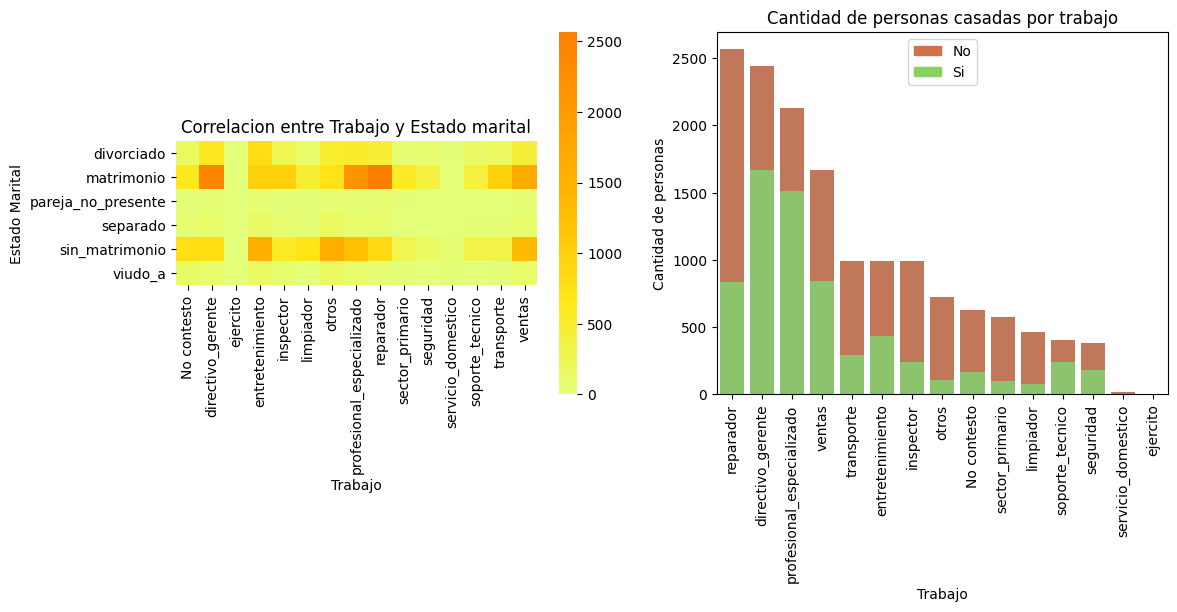

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df_temp = df.copy()

df_temp['unos'] = [1] * 32527
df_estado_marital= pd.pivot_table(
    df_temp,
    'unos',
    'estado_marital',
    'trabajo',
    'count',
    total.sort_values('tiene_alto_valor_adquisitivo', ascending = False)['trabajo']
).sort_index()
#Elimino intersecciones nulas
df_estado_marital = df_estado_marital.replace({np.nan: 0})



sns.heatmap(df_estado_marital, square=True, cmap="Wistia", ax = axes[0])
axes[0].set(xlabel='Trabajo', ylabel='Estado Marital', title='Correlacion entre Trabajo y Estado marital')


df_matrimonio = df[df['estado_marital'] == 'matrimonio']

total = df_matrimonio.groupby('trabajo')['tiene_alto_valor_adquisitivo'].sum().reset_index()
alto_valor = df_matrimonio[df_matrimonio.tiene_alto_valor_adquisitivo == 1].groupby('trabajo')['tiene_alto_valor_adquisitivo'].sum().reset_index()

alto_valor['tiene_alto_valor_adquisitivo'] = df_matrimonio[df_matrimonio.tiene_alto_valor_adquisitivo == 1].groupby('trabajo')['tiene_alto_valor_adquisitivo'].sum().reset_index()['tiene_alto_valor_adquisitivo'].tolist()
total['tiene_alto_valor_adquisitivo'] = df_matrimonio.groupby('trabajo')['anios_estudiados'].apply(lambda x: len(x)).tolist()


bar1 = sns.barplot(y="tiene_alto_valor_adquisitivo",  
                   x="trabajo", data=total, 
                   color='#D17049', 
                   order = total.sort_values('tiene_alto_valor_adquisitivo', ascending = False)['trabajo'],
                   ax = axes[1])

bar2 = sns.barplot(y="tiene_alto_valor_adquisitivo", 
                   x="trabajo", data=alto_valor, 
                   color='#89D15E', 
                   order = total.sort_values('tiene_alto_valor_adquisitivo', ascending = False)['trabajo'],
                   ax = axes[1])

top_bar = mpatches.Patch(color='#D17049', label='No')
bottom_bar = mpatches.Patch(color='#89D15E', label='Si')
axes[1].legend(handles=[top_bar, bottom_bar])
axes[1].set(xlabel = 'Trabajo', ylabel= 'Cantidad de personas', title = 'Cantidad de personas casadas por trabajo')
bar1.set_xticklabels(bar1.get_xticklabels(),rotation=90)
bar2.set_xticklabels(bar2.get_xticklabels(),rotation=90)

plt.show()

Encontramos que existe una relacion entre las profesiones con mayor porcentaje de poder de adquisitivo (gerente y profesional especializado) y el estado marital. Por lo que ahora queremos ver como se destribuye la polacion casada en los disintos trabajos.

Con el grafico de la derecha vemos que al condiccionar a la gente que tiene matrimonio, conservamos un porcentaje alto (84%) de la gente con poder adquisitivo alto, descartando tambien bastante poblacion de poder adquesitivo bajo (66%). Notamos que bajo esta condiccion ciertos porcentaje aumentaron considerablemente, son los casos de gerente y profesional especializado. Pero tambien estan los casos de ventas, entretenimiento, soporte tecnico y seguridad que tambien mejoraron la cantidad de personas con poder adqusitivo alto luego de condicionar.

#### ¿Que informacion nos aporta con respecto a la categoria de trabajo?

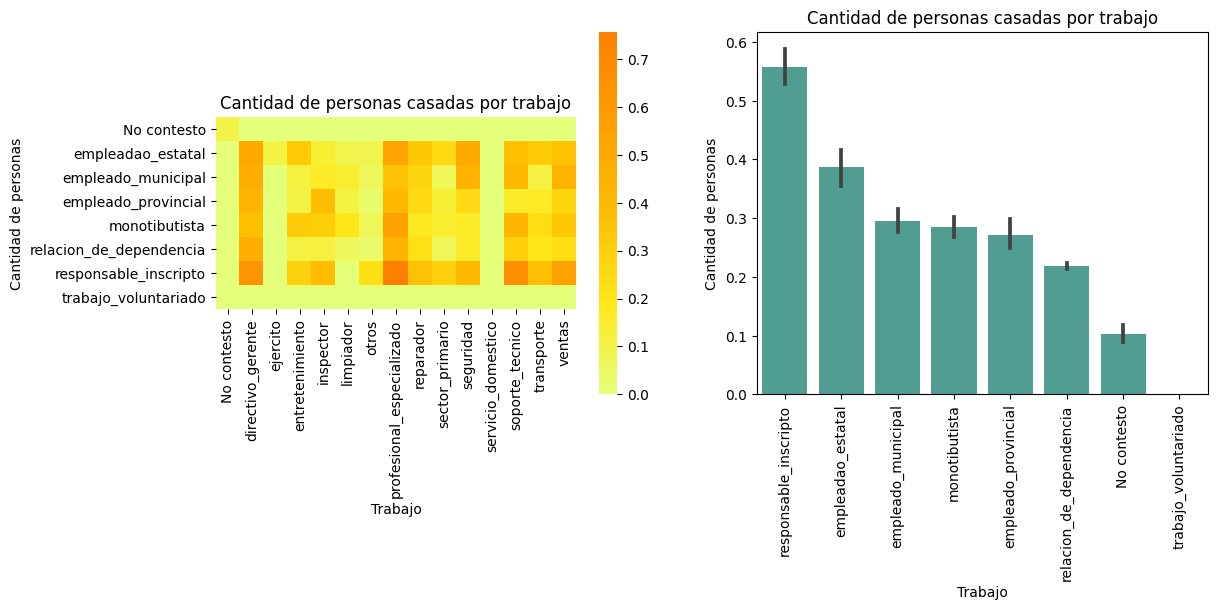

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df_temp['unos'] = [1] * 32527
df_tabla_trabajo= pd.pivot_table(
    df_temp,
    'tiene_alto_valor_adquisitivo',
    'categoria_de_trabajo',
    'trabajo',
    'mean',
    total.sort_values('tiene_alto_valor_adquisitivo', ascending = False)['trabajo']
).sort_index()
#Elimino intersecciones nulas
df_tabla_trabajo = df_tabla_trabajo.replace({np.nan: 0})

sns.heatmap(df_tabla_trabajo, square=True, cmap="Wistia",  ax = axes[0])
axes[0].set(xlabel = 'Trabajo', ylabel= 'Cantidad de personas', title = 'Cantidad de personas casadas por trabajo')

indices = df.groupby('categoria_de_trabajo')['tiene_alto_valor_adquisitivo'].aggregate(lambda x: np.mean(x))
bar = sns.barplot(
    data=df,
    x='categoria_de_trabajo',
    y='tiene_alto_valor_adquisitivo',
    color = (68/255,170/255 ,153/255),
    order= indices.sort_values(ascending=False).index,
    ax = axes[1])
bar.set_xticklabels(bar.get_xticklabels(),rotation=90)
axes[1].set(xlabel = 'Trabajo', ylabel= 'Cantidad de personas', title = 'Cantidad de personas casadas por trabajo')
plt.show()



Como podemos ver, si bien responsable inscripto es la categoria con mayor poder adquisitivo, notamos que la categoria de trabajo tiene poca incidencia sobre el poder adquisitivo y este esta mejor representado solo por el trabajo ya que las zonas oscuras forman rectas verticales lo que nos indica que la gente de mayor poder adquisitivo solo es inlfuida por la variable vertical que seria el trabajo

#### ¿Trabajar mas hace la diferencia?

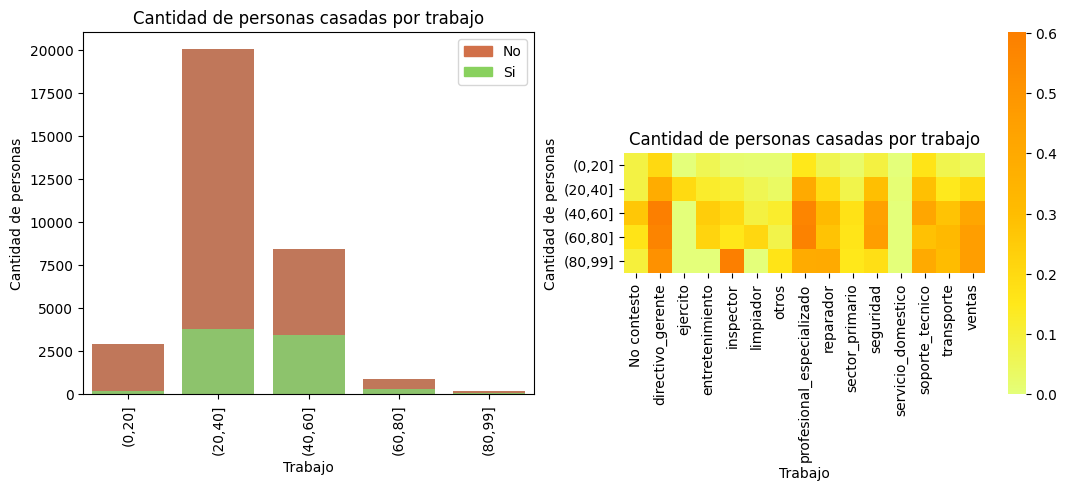

In [24]:
df_horas_categorizada = df[['tiene_alto_valor_adquisitivo','trabajo','horas_trabajo_registradas']].copy()
categoria = pd.cut(df_horas_categorizada.horas_trabajo_registradas,bins=[0,20,40,60,80,99],labels=['(0,20]', '(20,40]', '(40,60]', '(60,80]', '(80,99]'])
df_horas_categorizada.insert(2,"Grupo Horas de trabajo", categoria)
df_horas_categorizada


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

total = df_horas_categorizada.groupby('Grupo Horas de trabajo')['tiene_alto_valor_adquisitivo'].sum().reset_index()
df_temp = df_horas_categorizada.copy()






alto_valor = df_horas_categorizada[df_horas_categorizada.tiene_alto_valor_adquisitivo == 1].groupby('Grupo Horas de trabajo')['tiene_alto_valor_adquisitivo'].sum().reset_index()

alto_valor['tiene_alto_valor_adquisitivo'] = df_horas_categorizada[df_horas_categorizada.tiene_alto_valor_adquisitivo == 1].groupby('Grupo Horas de trabajo')['tiene_alto_valor_adquisitivo'].sum().reset_index()['tiene_alto_valor_adquisitivo'].tolist()
total['tiene_alto_valor_adquisitivo'] = df_horas_categorizada.groupby('Grupo Horas de trabajo')['horas_trabajo_registradas'].apply(lambda x: len(x)).tolist()

bar1 = sns.barplot(y="tiene_alto_valor_adquisitivo",  x="Grupo Horas de trabajo", data=total, color='#D17049', ax = axes[0])
bar2 = sns.barplot(y="tiene_alto_valor_adquisitivo", x="Grupo Horas de trabajo", data=alto_valor, color='#89D15E', ax = axes[0])

top_bar = mpatches.Patch(color='#D17049', label='No')
bottom_bar = mpatches.Patch(color='#89D15E', label='Si')
axes[0].legend(handles=[top_bar, bottom_bar])
axes[0].set(xlabel = 'Trabajo', ylabel= 'Cantidad de personas', title = 'Cantidad de personas casadas por trabajo')
bar1.set_xticklabels(bar1.get_xticklabels(),rotation=90)
bar2.set_xticklabels(bar2.get_xticklabels(),rotation=90)

df_temp['unos'] = [1] * 32527
df_tabla_trabajo= pd.pivot_table(
    df_temp,
    'tiene_alto_valor_adquisitivo',
    'Grupo Horas de trabajo',
    'trabajo',
    'mean',
    total.sort_values('tiene_alto_valor_adquisitivo', ascending = False)['Grupo Horas de trabajo']
).sort_index()
#Elimino intersecciones nulas
df_tabla_trabajo = df_tabla_trabajo.replace({np.nan: 0})

sns.heatmap(df_tabla_trabajo, square=True, cmap="Wistia",  ax = axes[1])
axes[1].set(xlabel = 'Trabajo', ylabel= 'Cantidad de personas', title = 'Cantidad de personas casadas por trabajo')


plt.show()

Podemos notar como el grafico anterior presenta dos grupos distintos, los que trabajan menos de 40 hs (70%) y los que trabajan mas de 40 hs (30%), entre el primero notamos que la gente que trabaja menos de 20 hs semanales definitivamente tiene un menor ingreso, mientras que la gente que cumple un horario mas tradicional de 8 hs diarias aumenta su porcentaje con respecto al anterior grupo pero no lo suficiente como para poder plantear una regla de decision satisfactoria, luego en el segundo grupo, vemos que el porcentaje relativo vuelve aumentar, pero aun mantiene una mayoria de gente con poder adquisitivo bajo, viendo las siguientes podemos notar la poca cantidad de personas en este grupo, haciendo que sea dificil inferir estadisticamente un patron basandonos en ellos. 

Analizando la correlacion con el trabajo podemos ver claramente que sucede lo mismo que para el caso anterior, las horas trabajadas terminan influyendo poco, lo que se manifiesta con las lineas verticales. A modo de respuesta a la pregunta se puede decir que no importa cuanto se trabaja sino de que se trabaja.

### ¿Que nivel de formacion academica es necesaria?

En general se esperaria que una persona con mas formacion califique para trabajos mas remunerados.

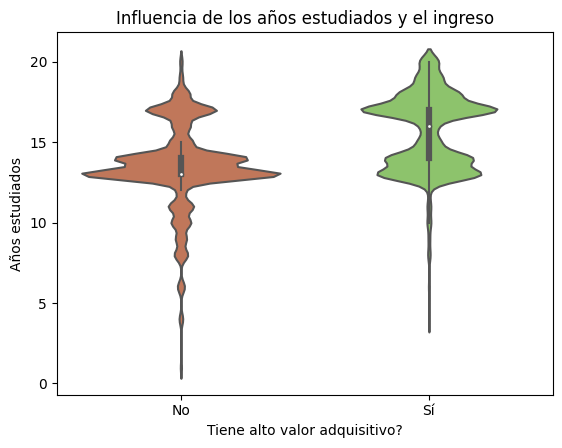

In [25]:
plt.figure(figsize=(6.4, 4.8),dpi=100)
plt.title("Influencia de los años estudiados y el ingreso")
sns.violinplot(
    data=df,
    y='anios_estudiados',
    x='tiene_alto_valor_adquisitivo',
    palette=['#D17049', "#89D15E"],
)
plt.ylabel("Años estudiados")
plt.xlabel("Tiene alto valor adquisitivo?")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

Podemos notar que existen 2 valores donde se acumula una gran parte de la poblacion. En estos se encuentras las personas que terminaron el secundario (13 años) y la universidad o estudios terciarios (17 años). Tambien podemos observar por debajo de 13 años la cantidad de personas con poder adquisitivo baja drasticamente, mientras que para el grupo con bajo poder adquesitivo va disminuyendo mas lentamente (Ocurre el analisis inverso para valores mayores a 17 años). 

#### ¿Que tanto influye la educacion en el trabajo?

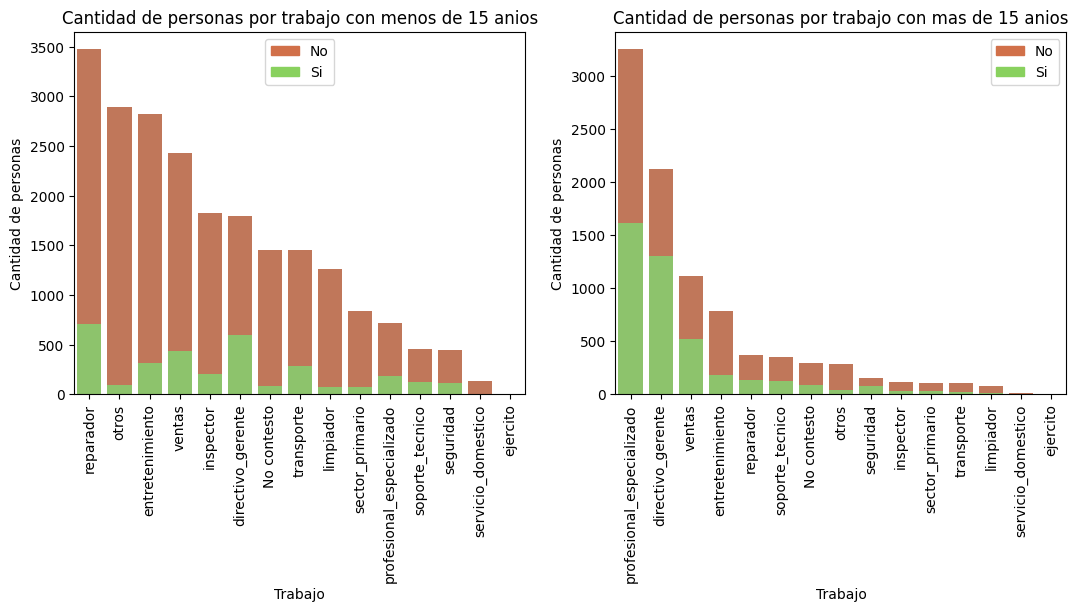

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)


df_menor_15 = df[df['anios_estudiados'] < 15]

total = df_menor_15.groupby('trabajo')['tiene_alto_valor_adquisitivo'].sum().reset_index()
alto_valor = df_menor_15[df_menor_15.tiene_alto_valor_adquisitivo == 1].groupby('trabajo')['tiene_alto_valor_adquisitivo'].sum().reset_index()

alto_valor['tiene_alto_valor_adquisitivo'] = df_menor_15[df_menor_15.tiene_alto_valor_adquisitivo == 1].groupby('trabajo')['tiene_alto_valor_adquisitivo'].sum().reset_index()['tiene_alto_valor_adquisitivo'].tolist()
total['tiene_alto_valor_adquisitivo'] = df_menor_15.groupby('trabajo')['anios_estudiados'].apply(lambda x: len(x)).tolist()


bar1 = sns.barplot(y="tiene_alto_valor_adquisitivo",  
                   x="trabajo", data=total, 
                   color='#D17049', 
                   order = total.sort_values('tiene_alto_valor_adquisitivo', ascending = False)['trabajo'],
                   ax = axes[0])

bar2 = sns.barplot(y="tiene_alto_valor_adquisitivo", 
                   x="trabajo", data=alto_valor, 
                   color='#89D15E', 
                   order = total.sort_values('tiene_alto_valor_adquisitivo', ascending = False)['trabajo'],
                   ax = axes[0])

top_bar = mpatches.Patch(color='#D17049', label='No')
bottom_bar = mpatches.Patch(color='#89D15E', label='Si')
axes[0].legend(handles=[top_bar, bottom_bar])
axes[0].set(xlabel = 'Trabajo', ylabel= 'Cantidad de personas', title = 'Cantidad de personas por trabajo con menos de 15 anios')
bar1.set_xticklabels(bar1.get_xticklabels(),rotation=90)
bar2.set_xticklabels(bar2.get_xticklabels(),rotation=90)



df_mayor_15 = df[df['anios_estudiados'] > 15]

total = df_mayor_15.groupby('trabajo')['tiene_alto_valor_adquisitivo'].sum().reset_index()
alto_valor = df_mayor_15[df_mayor_15.tiene_alto_valor_adquisitivo == 1].groupby('trabajo')['tiene_alto_valor_adquisitivo'].sum().reset_index()

alto_valor['tiene_alto_valor_adquisitivo'] = df_mayor_15[df_mayor_15.tiene_alto_valor_adquisitivo == 1].groupby('trabajo')['tiene_alto_valor_adquisitivo'].sum().reset_index()['tiene_alto_valor_adquisitivo'].tolist()
total['tiene_alto_valor_adquisitivo'] = df_mayor_15.groupby('trabajo')['anios_estudiados'].apply(lambda x: len(x)).tolist()


bar1 = sns.barplot(y="tiene_alto_valor_adquisitivo",  
                   x="trabajo", data=total, 
                   color='#D17049', 
                   order = total.sort_values('tiene_alto_valor_adquisitivo', ascending = False)['trabajo'],
                   ax = axes[1])

bar2 = sns.barplot(y="tiene_alto_valor_adquisitivo", 
                   x="trabajo", data=alto_valor, 
                   color='#89D15E', 
                   order = total.sort_values('tiene_alto_valor_adquisitivo', ascending = False)['trabajo'],
                   ax = axes[1])

top_bar = mpatches.Patch(color='#D17049', label='No')
bottom_bar = mpatches.Patch(color='#89D15E', label='Si')
axes[1].legend(handles=[top_bar, bottom_bar])
axes[1].set(xlabel = 'Trabajo', ylabel= 'Cantidad de personas', title = 'Cantidad de personas por trabajo con mas de 15 anios')
bar1.set_xticklabels(bar1.get_xticklabels(),rotation=90)
bar2.set_xticklabels(bar2.get_xticklabels(),rotation=90)
plt.show()

Como habiamos viste existe dos focos importante donde se agrupa la mayor cantidad de gente y como podemos ver las personas con alto poder adquisitivo tienden a tener una mayor educacion. Observamos que la separacion no es tan marcada como por estado marital.

### ¿Es realmente influyente el domicilio legal?

En general existe el preasuncion de que la zona en la que una personas vive es reflajo de su poder adquisitivo.

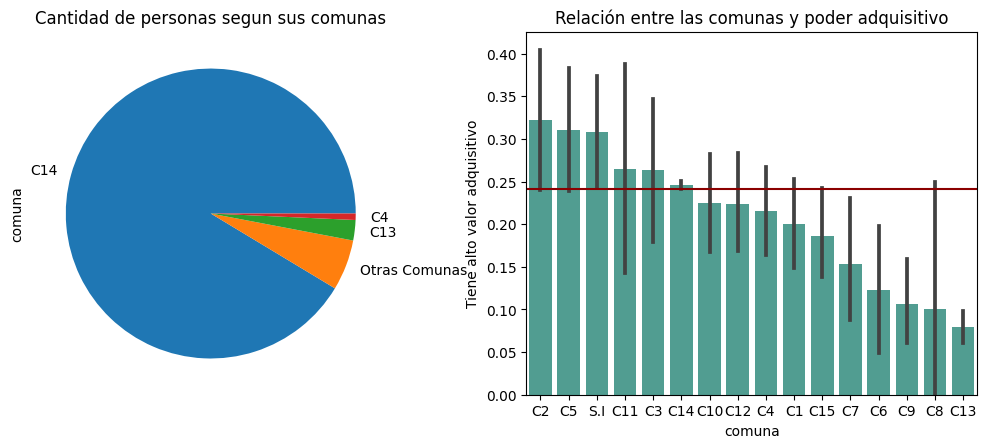

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)


df_cantidades = df[['comuna', 'tiene_alto_valor_adquisitivo', 'estado_marital']].copy()

df_cantidades.loc[df_cantidades['comuna'].isin((df_cantidades['comuna'].value_counts()[df_cantidades['comuna'].value_counts() < 232]).index), 'comuna'] = 'Otras Comunas'
cantidades = df_cantidades['comuna'].value_counts()

cantidades.plot(
    kind='pie',
    ax = axes[0]
)
axes[0].set(title = 'Cantidad de personas segun sus comunas')


df_comunas = df[['comuna', 'tiene_alto_valor_adquisitivo']].copy()
indices = df_comunas.groupby('comuna')['tiene_alto_valor_adquisitivo'].aggregate(lambda x: np.mean(x))

ax = sns.barplot(
    data=df_comunas,
    x='comuna',
    y='tiene_alto_valor_adquisitivo',
    order= indices.sort_values(ascending=False).index,
    ax = axes[1],
    color = (68/255,170/255 ,153/255)
)

prom = df['tiene_alto_valor_adquisitivo'].mean()
axes[1].set(xlabel = 'comuna', ylabel = 'Tiene alto valor adquisitivo', title = 'Relación entre las comunas y poder adquisitivo')
axes[1].axhline(prom, color="darkred", label="Promedio de personas con alto VA")
plt.show()

Podemos ver la gran cantidad de personas que reciden en palermo (un 90%), mientras que en el resto de comunas no hay la sufuientes personas como para poder inferir estadisticamente sobre alguna relacion entre el barrio y el poder adquisitivo.

### Tomando a la edad como un indicador promedio en la experiencia laboral. ¿Que tanto peso tiene con respecto a la capacidad financiera?

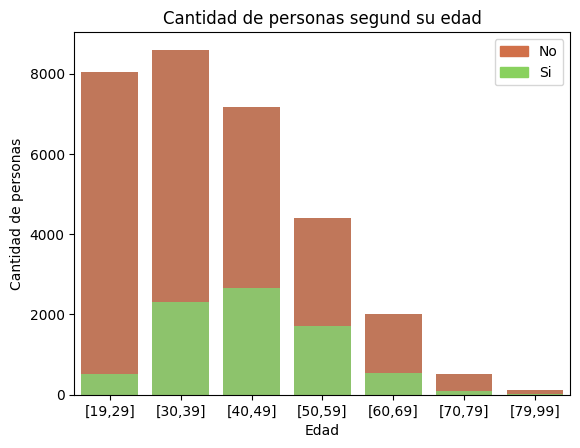

In [28]:
plt.figure(figsize=(6.4, 4.8),  dpi=100)

df_edad_categorizada = df[['edad', 'tiene_alto_valor_adquisitivo','trabajo','estado_marital']].copy()
categoria = pd.cut(df_edad_categorizada.edad,bins=[19,29,39,49,59,69,79,99],labels=['[19,29]', '[30,39]', '[40,49]', '[50,59]', '[60,69]', '[70,79]','[79,99]'])
df_edad_categorizada.insert(2,"Edad grupo", categoria)
df_edad_categorizada


total = df_edad_categorizada.groupby('Edad grupo')['tiene_alto_valor_adquisitivo'].sum().reset_index()
alto_valor = df_edad_categorizada[df_edad_categorizada.tiene_alto_valor_adquisitivo == 1].groupby('Edad grupo')['tiene_alto_valor_adquisitivo'].sum().reset_index()

alto_valor['tiene_alto_valor_adquisitivo'] = df_edad_categorizada[df_edad_categorizada.tiene_alto_valor_adquisitivo == 1].groupby('Edad grupo')['tiene_alto_valor_adquisitivo'].sum().reset_index()['tiene_alto_valor_adquisitivo'].tolist()
total['tiene_alto_valor_adquisitivo'] = df_edad_categorizada.groupby('Edad grupo')['edad'].apply(lambda x: len(x)).tolist()

bar1 = sns.barplot(y="tiene_alto_valor_adquisitivo",  x="Edad grupo", data=total, color='#D17049')
bar2 = sns.barplot(y="tiene_alto_valor_adquisitivo", x="Edad grupo", data=alto_valor, color='#89D15E')

top_bar = mpatches.Patch(color='#D17049', label='No')
bottom_bar = mpatches.Patch(color='#89D15E', label='Si')
plt.legend(handles=[top_bar, bottom_bar])
plt.title("Cantidad de personas segund su edad")
plt.ylabel("Cantidad de personas")
plt.xlabel("Edad")


plt.show()

Podemos ver una clara diferencia en la distribucion de las personas. El pico de gente con poder adquisitivo es de 45 años mientras que el de las personas con bajo poder adquisitivo es de 20 años.

Si bien es clara la existenciade un patron distinto para cada uno de los grupos, la cantidad de personas de bajo poder adquisitovo dobla a la cantidad de personas de alto poder adquisitivo en el pico de esta ultima. Lo que hace dificil encontra una regla para poder separarlos eficientemente.

#### ¿Existe una relacion entre el trabajo o el estado marital y la edad de una persona?

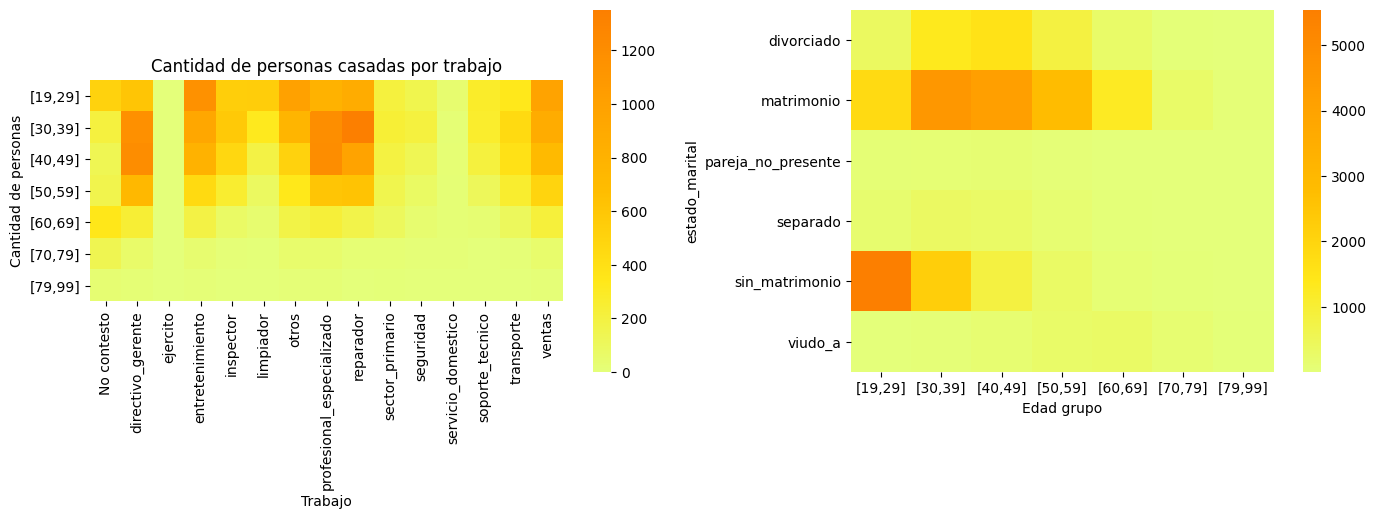

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[8.4 * 2, 4.8], dpi=100)


#plt.figure(figsize=(6.4, 4.8),  dpi=100)

df_temp = df_edad_categorizada.copy()

df_temp['unos'] = [1] * 32527
df_edad_trabajo= pd.pivot_table(
    df_temp,
    'unos',
    'Edad grupo',
    'trabajo',
    'count',
).sort_index()
#Elimino intersecciones nulas
df_edad_trabajo = df_edad_trabajo.replace({np.nan: 0})

sns.heatmap(df_edad_trabajo, square=True, cmap="Wistia", ax= axes[0])
axes[0].set(xlabel = 'Trabajo', ylabel= 'Cantidad de personas', title = 'Cantidad de personas casadas por trabajo')


#plt.figure(figsize=(6.4, 4.8),  dpi=100)


df_temp['unos'] = [1] * 32527
df_edad_trabajo= pd.pivot_table(
    df_temp,
    'unos',
    'estado_marital',
    'Edad grupo',
    'count',
).sort_index()
#Elimino intersecciones nulas
df_edad_trabajo = df_edad_trabajo.replace({np.nan: 0})

sns.heatmap(df_edad_trabajo, square=True, cmap="Wistia", ax= axes[1])
axes[0].set(xlabel = 'Trabajo', ylabel= 'Cantidad de personas', title = 'Cantidad de personas casadas por trabajo')
plt.show()

Como podemos ver existen varios grupos visibles en el grafico, por un lado sabemos que todas las personas que tiene entre 19 y 29 años en su gran mayoria son personas con bajo poder adquisitivo (debido a lo visto en el grafico anterior). Luego en la franca que va desde 30 hasta 50 años podemos distinguir 3 de profesiones con una gran cantidad de personas: gerente, profesional especializado y reparador. Por lo que podes concluir que si bien parece existir un patron.

Tambien al analizar la relacion que existe con el estado marital notamos dos grupos bien distinguido. El que nos interesa es la seccion de gente entre 30 y 60 años los cuales princialmente se acumulan en la categoria de matrimonio.

Si bien existe la relacion entre la edad y estas variables, condicionar por el matrimonio resulta similar a pedir que la poblacion tenga mas de 29 años que es un grupo con bajo poder adquisitivo y por navaja de Ockham un modelo que logra lo mismo y pide menos es mejor que uno que pide mas.

### ¿Es influyente factores como la religion o el genero para determinar el poder adquisitivo?

A priori uno creeria que la religion de una persona no afectaria en su poder adquisitio. Mientras que existe una posibilidad de una desigualdad basada en el genero.

#### Religion

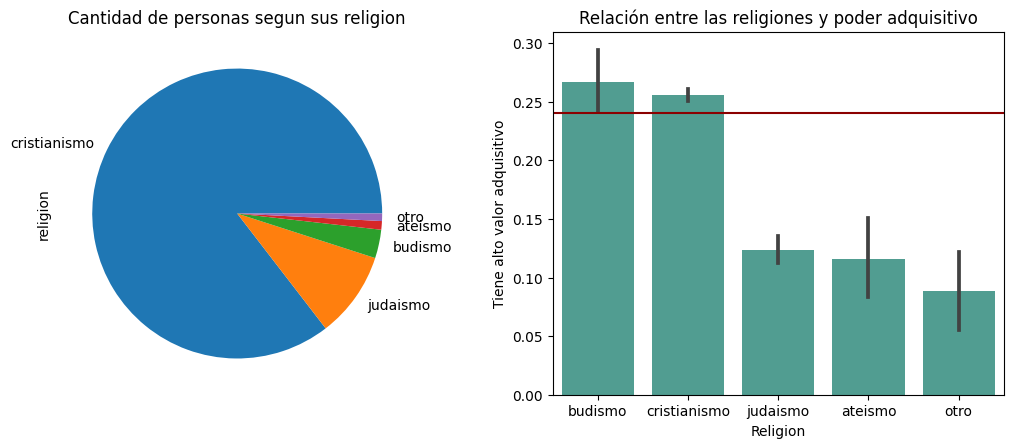

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df['religion'].value_counts().plot(
    kind='pie',
     ax = axes[0],
)
axes[0].set(title = 'Cantidad de personas segun sus religion')


df_religion = df[['religion', 'tiene_alto_valor_adquisitivo']].copy()
indices = df_religion.groupby('religion')['tiene_alto_valor_adquisitivo'].aggregate(lambda x: np.mean(x))

sns.barplot(
    data=df_religion,
    x='religion',
    y='tiene_alto_valor_adquisitivo',
    order= indices.sort_values(ascending=False).index,
    ax = axes[1],
    color = (68/255,170/255 ,153/255)
)

prom = df['tiene_alto_valor_adquisitivo'].mean()
axes[1].set(xlabel = 'Religion', ylabel = 'Tiene alto valor adquisitivo', title = 'Relación entre las religiones y poder adquisitivo')
axes[1].axhline(prom, color="darkred", label="Promedio de personas con alto VA")
plt.show()

Como podemos ver la gran mayoria de personas son cristiana, luego existen dos grupos mas reducidos que son el judaismo y el budismo ya que tanto el ateismo como la categoria 'otros' tiene muy poca gente como para poder inferir algo apartir de ellas. .

Algo interesetante es la baja cantidad de personas judias con alto poder adquisitivo, para buscar una explicacion a esto decidimos graficar la religion contra variables que ya sabemos, por el analisis antes hecho, que son influyentes en el poder adquisitivo.

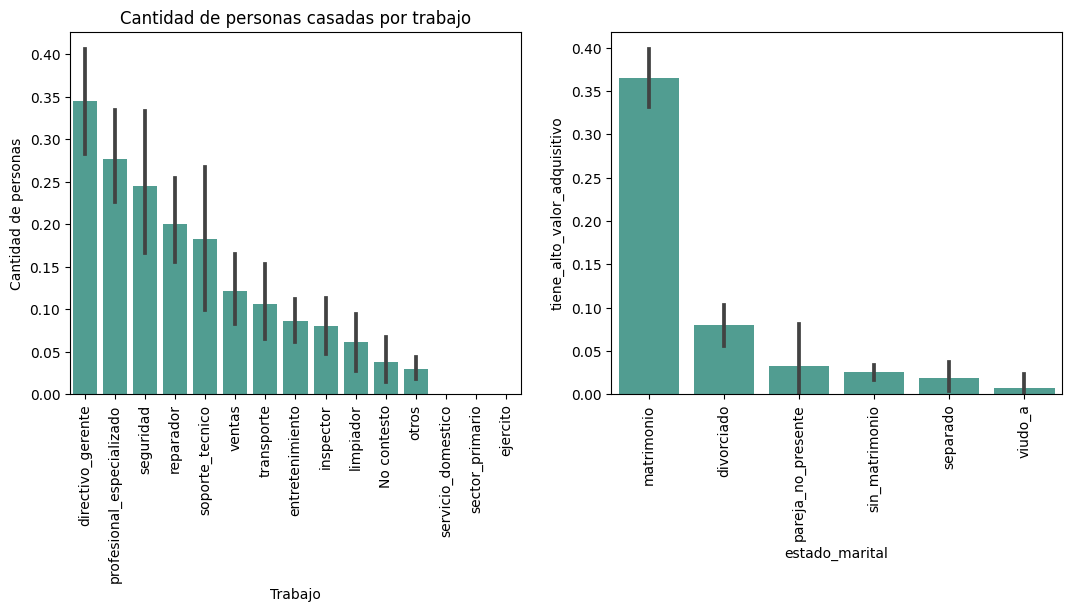

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df_sin_crist = df[df['religion'] == 'judaismo']

indices = df_sin_crist.groupby('trabajo')['tiene_alto_valor_adquisitivo'].aggregate(lambda x: np.mean(x))

bar1=sns.barplot(
    data=df_sin_crist,
    x='trabajo',
    y='tiene_alto_valor_adquisitivo',
    order= indices.sort_values(ascending=False).index,
    ax = axes[0],
    color = (68/255,170/255 ,153/255)
)
axes[0].set(xlabel = 'Trabajo', ylabel= 'Cantidad de personas', title = 'Cantidad de personas casadas por trabajo')

bar2=sns.barplot(
    data=df_sin_crist,
    x='estado_marital',
    y='tiene_alto_valor_adquisitivo',
    order= df_sin_crist.groupby('estado_marital')['tiene_alto_valor_adquisitivo'].aggregate(lambda x: np.mean(x)).sort_values(ascending=False).index,
    ax = axes[1],
    color = (68/255,170/255 ,153/255)
)

bar1.set_xticklabels(bar1.get_xticklabels(),rotation=90)
bar2.set_xticklabels(bar2.get_xticklabels(),rotation=90)

plt.show()

Mirando estos graficos podemos notar que este porcentaje bajo de personas con alto poder adquisitivo que tenia la religio judia, se debia a que solo un tercio de ellos estan casados y tiene trabajos con alta remuneracion como gerente y porfesionales espesializados.

#### Genero

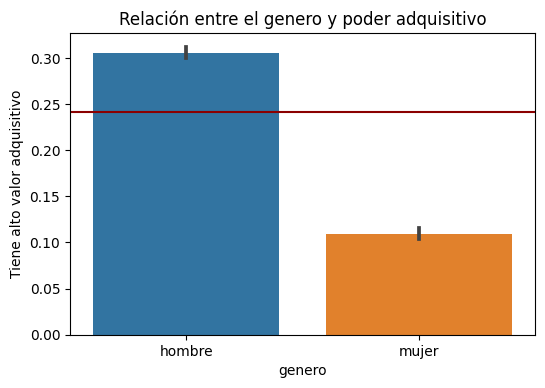

In [32]:
plt.figure(dpi=100)

ax = sns.barplot(
    data=df,
    y='tiene_alto_valor_adquisitivo',
    x='genero')


plt.xlabel("genero")
plt.ylabel("Tiene alto valor adquisitivo")
plt.title('Relación entre el genero y poder adquisitivo')
prom = df['tiene_alto_valor_adquisitivo'].mean()
plt.axhline(prom, color="darkred", label="Promedio de personas con alto VA")
plt.show()

Notamos una importante diferencia ente la cantidad de hombre y mujeres con alto poder adquisitivo. Por lo que decidimos buscar relaciones entre esta variable y las antes analizadas.

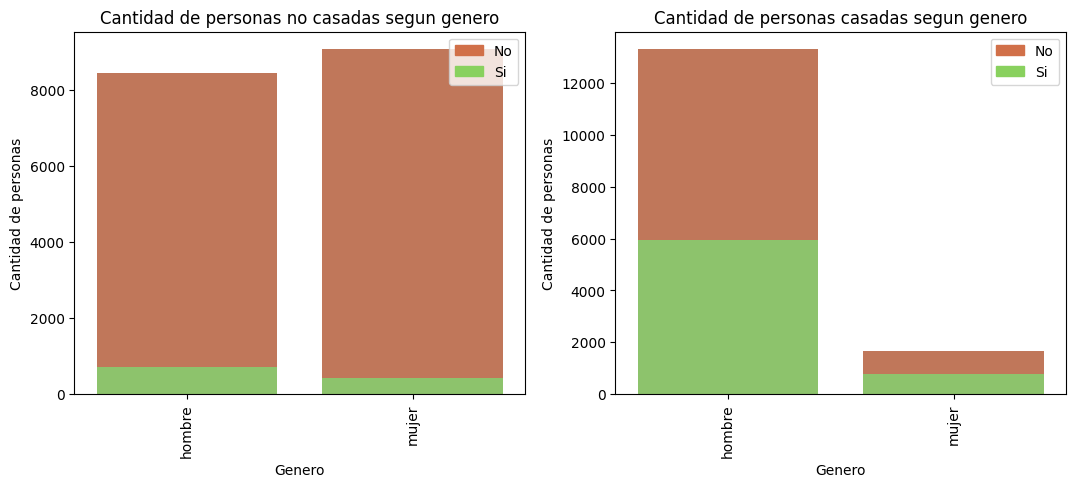

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df_no_mat = df[df['estado_marital'] != 'matrimonio']
df_mat = df[df['estado_marital'] == 'matrimonio']

total = df_no_mat.groupby('genero')['tiene_alto_valor_adquisitivo'].sum().reset_index()
alto_valor = df_no_mat[df_no_mat.tiene_alto_valor_adquisitivo == 1].groupby('genero')['tiene_alto_valor_adquisitivo'].sum().reset_index()

alto_valor['tiene_alto_valor_adquisitivo'] = df_no_mat[df_no_mat.tiene_alto_valor_adquisitivo == 1].groupby('genero')['tiene_alto_valor_adquisitivo'].sum().reset_index()['tiene_alto_valor_adquisitivo'].tolist()
total['tiene_alto_valor_adquisitivo'] = df_no_mat.groupby('genero')['anios_estudiados'].apply(lambda x: len(x)).tolist()


bar1 = sns.barplot(y="tiene_alto_valor_adquisitivo",  
                   x="genero", data=total, 
                   color='#D17049',
                   ax = axes[0])

bar2 = sns.barplot(y="tiene_alto_valor_adquisitivo", 
                   x="genero", data=alto_valor, 
                   color='#89D15E', 
                   ax = axes[0])

top_bar = mpatches.Patch(color='#D17049', label='No')
bottom_bar = mpatches.Patch(color='#89D15E', label='Si')
axes[0].legend(handles=[top_bar, bottom_bar])
axes[0].set(xlabel = 'Genero', ylabel= 'Cantidad de personas', title = 'Cantidad de personas no casadas segun genero')
bar1.set_xticklabels(bar1.get_xticklabels(),rotation=90)
bar2.set_xticklabels(bar2.get_xticklabels(),rotation=90)




total = df_mat.groupby('genero')['tiene_alto_valor_adquisitivo'].sum().reset_index()
alto_valor = df_mat[df_mat.tiene_alto_valor_adquisitivo == 1].groupby('genero')['tiene_alto_valor_adquisitivo'].sum().reset_index()

alto_valor['tiene_alto_valor_adquisitivo'] = df_mat[df_mat.tiene_alto_valor_adquisitivo == 1].groupby('genero')['tiene_alto_valor_adquisitivo'].sum().reset_index()['tiene_alto_valor_adquisitivo'].tolist()
total['tiene_alto_valor_adquisitivo'] = df_mat.groupby('genero')['anios_estudiados'].apply(lambda x: len(x)).tolist()


bar1 = sns.barplot(y="tiene_alto_valor_adquisitivo",  
                   x="genero", data=total, 
                   color='#D17049', 
                   ax = axes[1])

bar2 = sns.barplot(y="tiene_alto_valor_adquisitivo", 
                   x="genero", data=alto_valor, 
                   color='#89D15E', 
                   ax = axes[1])

top_bar = mpatches.Patch(color='#D17049', label='No')
bottom_bar = mpatches.Patch(color='#89D15E', label='Si')
axes[1].legend(handles=[top_bar, bottom_bar])
axes[1].set(xlabel = 'Genero', ylabel= 'Cantidad de personas', title = 'Cantidad de personas casadas segun genero')
bar1.set_xticklabels(bar1.get_xticklabels(),rotation=90)
bar2.set_xticklabels(bar2.get_xticklabels(),rotation=90)
plt.show()

Como podemos observar si bien las mujeres poseen menor poder adquisitivo que los hombres, al condicionar por el matrimonio se forman dos ramas en las que el genero deja de ser influyente, ya que ambas poseen el mismo porcentaje relativo

## Conclusion:

A partir de los datos recolectados hemos podido obtener las siguientes conclusiones:
- La gente que se encuentra casada posee el mayor porcentaje de gente con poder adquisitivo alto siendo este el 84% de la gente con poder adquisitivo alto, y llevandose un 32% de la gente de poder adquisitivo bajo, sin lugar a dudas tener una familia que mantener impulsa a los integrantes a ganar mas de los que no.
- Hay trabajos que son mejores remunerados que otros siendo estos directivo gerente, profesional especializado y ventas, esto por si solo resulta no tan bueno como lo anterior, pero condicionada con lo anterior se vuelve una gran regla de decision, tan solo el 9% de la gente con bajo poder adquisitivo cumple esta condicion, por lo que el error que se comete es despreciable 
- La formacion academica comparada con el trabajo nos muestra que tener una formacion de mayor de 15 años influye en el poder adquisitivo permitiendo ayudarnos a recuperar a un 10% de gente de poder adquisitivo alto, que no cumplia la condicion del trabajo
- La edad si bien posee una interesante separacion no resulta tan importante a la hora de analizar el perfil de persona con poder adquisitivo que se fue armando, en parte por la similitud que tiene con otras condiciones como pedir que las personas esten casadas.
- El genero si bien presento una interesante diferencia, siendo condicionada al matrimonio se distribuyo de forma similar perdiendo la influencia inicial
- El barrio o en este caso las comunas no parecen influir tanto como uno puede llegar a presuponer, quiza pueda estar influenciado que el 90% de la muestra es solo de Palermo
- La religion solo presento un caso fuera de lo comun siendo este la religion judia pero analizandola mas en detalle se debio a que solo 1/3 de ellos se encontraban en categorias mas influyentes como estar casados o trabajar en puestos altamente remunerados, por lo cual se decidio no tenerla en cuenta

Por lo que como target, recomendamos basarse fuertemente en las personas que se encuentran en matrimonio y que poseen trabajos altamente remunerados como directivo gerente, profesional especializado o ventas, en caso de no poder satisfacer esta ultima condicion pudimos verificar que la gente que estudio mas de 15 años por lo general son lo suficiente competentes como para poder satisfacer la condicion pedida.

## Baseline:

In [34]:
def baseline(X: pd.DataFrame):
    df = X.reset_index()
    # Inicializamos el vector de prediccion inicialmente con 0 y
    #vamos agregando las condiciones que creemos fundamentales
    pred = pd.Series(np.zeros(len(df)))
    
    # Primera condicion importante de nuestro baseline,
    # con ella separamos una gran parte de la poblacion 
    # 17550 que No y 14484 que Si
    # En el No cometemos tan solo un error en 1253,
    # Mientras que en el Si cometemos 
    # un error de 14484 personas (en caso de terminar el baseline aqui).
    # Es una buena condicion ya que nos permite quedarnos con el 
    # 85% de la gente de poder adquisitivo alto
    sos_casado = df['estado_marital'] == 'matrimonio'
    
    # Segunda condicion, anexada al Si de la condicion anterior
    # nos permite quedarnos en el caso de que la 
    # respueta sea satisfactoria con el 51% de la gente de poder adquisitivo alto
    # mientras que solo cometemos un error de 2222 personas.
    # Quedando en la rama del No solo un 34% de la gente con poder adquisitivo alto
    # y cometiendo un error de 2664 personas
    trabajas_en_puestos_importantes = (df['trabajo'] == 'directivo_gerente') | (df['trabajo'] == 'profesional_especializado') | (df['trabajo'] == 'ventas')
    
    # Tercera condicion que nos permite recuperar gente de la rama del no anterior,
    # anexada a las anteriores nos permite recuperar el 10% de la gente de poder adquisitivo alto,
    # cometiendo error en solo 1523 personas,
    # mientras que para el caso de los que no la cumplen solo cometemos
    # error en 1881 personas
    estudiaste_15_o_mas_anios = df['anios_estudiados'] >= 14.5
    
    # Armando las ramas
    sos_casado_y_ocupas_un_puesto_importante = sos_casado & trabajas_en_puestos_importantes
    sos_casado_y_no_ocupas_un_puesto_importante_y_si_estudiaste__mas_14_anios = sos_casado & (~trabajas_en_puestos_importantes) & estudiaste_15_o_mas_anios
    
    #Finalemente seteando en el vector de prediccion las condiciones 
    # que cosnideramos que cumple una persona con alto poder adquisitivo
    pred[sos_casado_y_ocupas_un_puesto_importante | sos_casado_y_no_ocupas_un_puesto_importante_y_si_estudiaste__mas_14_anios] = 1
    return pred.tolist()

#### Arbol de decision
![Arbol de decision](arbol.png)

In [35]:
np.mean(df['tiene_alto_valor_adquisitivo'] == baseline(df))

0.8122175423494328